# Details - Max Mean Activation
This notebook complements the [docs](https://luminovo.gitlab.io/midnite) and explains the modular max mean activation optimization method in detail.

Max mean activation is an optimization in image space to maximize the mean of activations of some selected neurons.

In [1]:
%%capture
%matplotlib inline  
%load_ext autoreload
%autoreload 2  
%cd ../src

## Preparation: Load Pretrained Model
As in other examples, we use a pre-trained alexnet.

In [2]:
import torchvision.models as models
from torch.nn.modules import Softmax

alexnet = models.alexnet(pretrained=True)
alexnet.classifier.add_module("softmax", Softmax(dim=1))
alexnet.eval();

## Channelwise Regularization/Transformation Comparisons
Regularization is the most important part for max mean activation to pick up the information that is required. In the following, we will examine the effect of different regularizers.
### Baseline: No Regularization
For illustration, we optimize for some channel of the 9th feature layer in alexnet.

100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


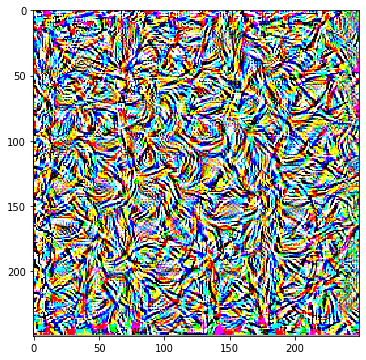

In [3]:
from midnite.visualization.base import *
from plot_utils import show

show(PixelActivation(
    alexnet.features[:9],
    SplitSelector(ChannelSplit(), [1]),
).visualize())

### Weight Decay
Decays the gradient during optimization, i.e. causes less relevant parts of the optimized image to vanish.

100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


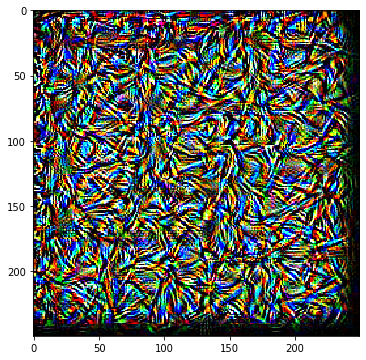

In [4]:
show(PixelActivation(
    alexnet.features[:9],
    SplitSelector(ChannelSplit(), [1]),
    regularization = [WeightDecay(decay_factor=1e-3)]
).visualize())

### Blur Filter
Performs simple blurring after each iteration. However, blurring has the issue that edges are not preserved.

100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


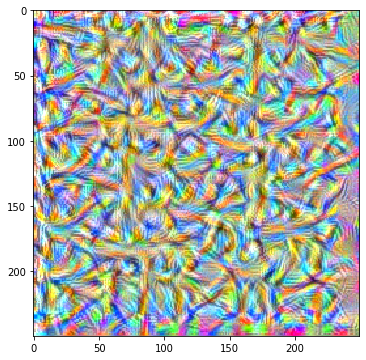

In [5]:
show(PixelActivation(
    alexnet.features[:9],
    SplitSelector(ChannelSplit(), [1]),
    transform = BlurTransform()
).visualize())

### Bilateral Filter
Very similar to blurring, but preserves edges.

100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


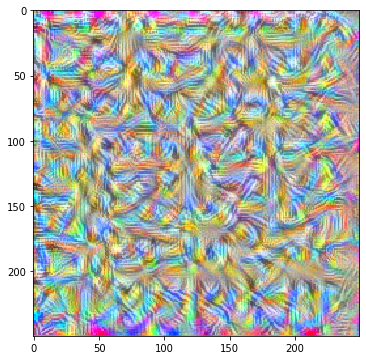

In [6]:
show(PixelActivation(
    alexnet.features[:9],
    SplitSelector(ChannelSplit(), [1]),
    transform=BilateralTransform()
).visualize())

### Random Robustness Transformations
After each iteration, random translation, rotation, and scaling are applied. The resulting optimized image is then robust to such transformations.

100%|██████████| 12/12 [00:04<00:00,  3.00it/s]


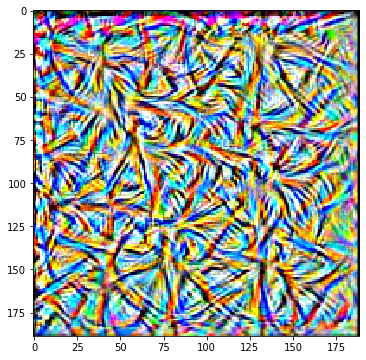

In [7]:
show(PixelActivation(
    alexnet.features[:9],
    SplitSelector(ChannelSplit(), [1]),
    transform=RandomTransform()
).visualize())

### Resizing Transform
Image is scaled after each iteration.
This has the advantage that low-frequency patterns can be picked up more easily.
Since the image is scaled up after each step, we use an initial size of 50 pixels (instead of the default 250).

100%|██████████| 12/12 [00:03<00:00,  1.95it/s]


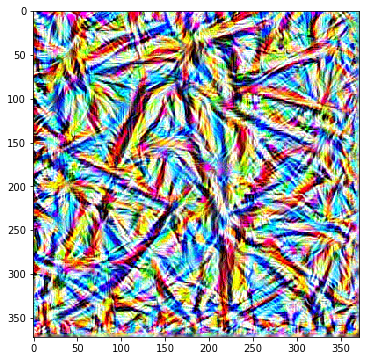

In [8]:
show(PixelActivation(
    alexnet.features[:9],
    SplitSelector(ChannelSplit(), [1]),
    transform=ResizeTransform(),
    init_size=50
).visualize())

### Total Variation Regularizer
During optimization, adds total variation to the loss (punishes difference in adjacent pixels).

100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


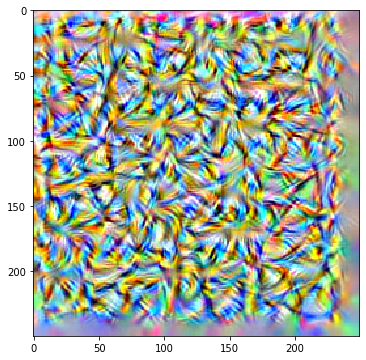

In [9]:
show(PixelActivation(
    alexnet.features[:9],
    SplitSelector(ChannelSplit(), [1]),
    regularization=[TVRegularization(coefficient=5e2)]
).visualize())

## Combining Regularizers
To obtain a better image, we use:
 - weight decay to gray out irrelevant parts
 - blur (or biliteral filter) for penalizing high-frequency noise
 - resizing to capture low-frequency patterns
 - random transformations to get robust image
 - total variation to get more natural looking image

100%|██████████| 12/12 [00:06<00:00,  1.18s/it]


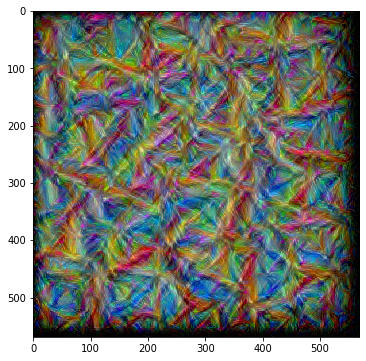

In [10]:
show(PixelActivation(
    alexnet.features[:9],
    SplitSelector(ChannelSplit(), [1]),
    transform=RandomTransform()+BlurTransform()+ResizeTransform(),
    regularization=[TVRegularization(), WeightDecay(decay_factor=3e-4)],
    init_size=50,
).visualize())

## Optimization Parameters
For our optimization, the relevant parameters are:
 - lr: learning rate for optimization
 - iter_n: number of iterations - transforms and regularizers are applied after each iteration
 - opt_n: number of optimization steps per iteration

Image transformations and filters are only applied after each iteration. Apart from that, the parameters behave as in any optimization.

In the following, we have a look at a few examples:

100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


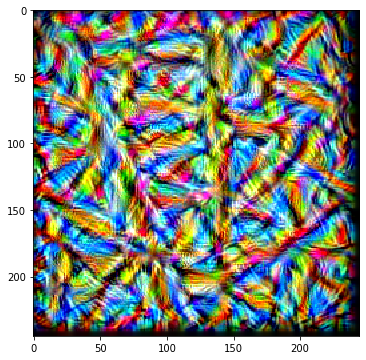

100%|██████████| 50/50 [00:01<00:00, 46.20it/s]


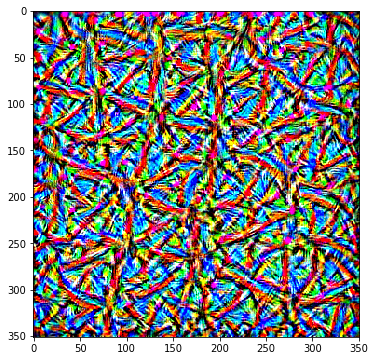

In [11]:
import midnite

# use 'cpu' if no GPU available
with midnite.device('cuda:0'):
    show(PixelActivation(
        alexnet.features[:9],
        SplitSelector(ChannelSplit(), [1]),
        transform=RandomTransform()+BlurTransform()+ResizeTransform(),
        regularization=[TVRegularization(), WeightDecay(decay_factor=3e-4)],
        init_size=100,
        lr=0.001, # default: 0.01
        iter_n=5, # default: 12
        opt_n=500, # default: 20
    ).visualize())
    
    show(PixelActivation(
        alexnet.features[:9],
        SplitSelector(ChannelSplit(), [1]),
        transform=RandomTransform()+BlurTransform()+ResizeTransform(scale_fac=1.05),
        regularization=[TVRegularization(), WeightDecay(decay_factor=6e-5)],
        init_size=25,
        lr=0.1, # default: 0.01
        iter_n=50, # default: 12
        opt_n=10, # default: 20
    ).visualize())
    

## Neuron Selections for Optimizaiton

Using an appropriate `NeuronSelector`, we can create an activaiton optimization for any selection neurons. 

### Example 1: Single Neuron
Note how some parts of the image do not have any influence on the gradient, since the convolutions have not yet progressed as far.

100%|██████████| 12/12 [00:06<00:00,  1.67it/s]


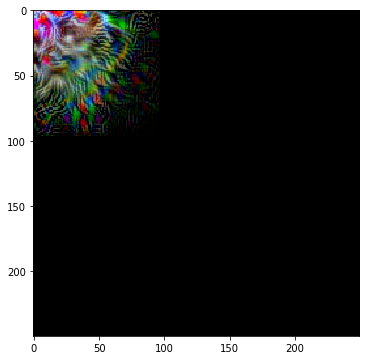

In [12]:
show(PixelActivation(
    alexnet.features[:11],
    SplitSelector(NeuronSplit(), [0, 0, 0]),
    transform=BlurTransform(),
    regularization=[WeightDecay(decay_factor=1e-2)]
).visualize())

## Example 2: Class Visualization
We can optimize for a target class to obtain an image of what the networks understand as that class. In this example, we do this on a GoogLeNet (due to the stronger visual semantics) for imagenet class 783 (Screw).

100%|██████████| 300/300 [02:44<00:00,  1.46s/it]


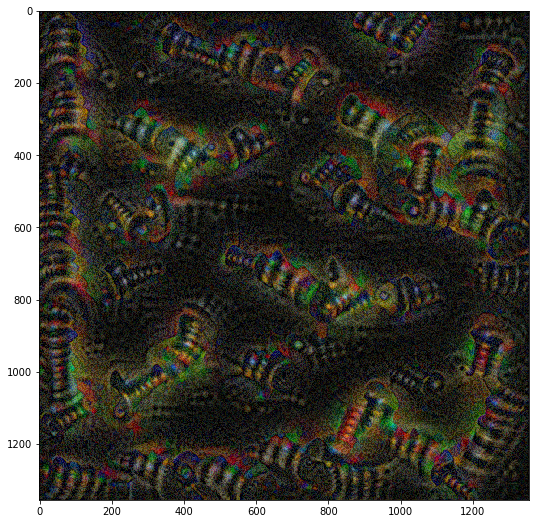

In [13]:
from torch.nn import Sequential, Softmax
from plot_utils import show_normalized

googlenet = Sequential(models.googlenet(pretrained=True), Softmax(dim=1))
googlenet.eval()

with midnite.device('cuda:0'):
    show_normalized(PixelActivation(
        googlenet,
        SplitSelector(NeuronSplit(), [783]),
        transform=RandomTransform(scale_fac=0)+BilateralTransform()+ResizeTransform(1.005),
        opt_n=10,
        iter_n=300,
        regularization=[WeightDecay(decay_factor=1.5e-7), TVRegularization(coefficient=0.05)],
        init_size=300,
        lr=0.007
    ).visualize(), scale=1.5)